# Background
Scientists define there to be two main types of age: chronological, and biological age. Chronological age is based on how long you have been alive (years since birth), whereas biological age is a rough estimate of how healthy your body is by measuring various different biomarkers. For more information on this, check out my recent article on biological age right here: [What is Biological Age?](https://medium.com/biotein/what-is-biological-age-383692f53e60)

One way of determining biological age (as also described in the article) is to measure the methylation levels in your genome. At sites known as CpG sites, along your DNA, various proteins can add on or remove methyl groups, in order to control which genes are expressed into proteins, and which ones aren't. As you age, however, the systems responsible for maintaining this control of the genome begin to break down, leading to errors in methylation. As such, some sites begin to see an accumulation of methyl tags, while others have their tags removed, as you age.

Dr. Steve Horvath, longevity researcher at University of California Los Angeles, used this progression to develop a system known as the Horvath aging clock, which is able to produce an accurate estimate of your biological age. For example, after analyzing the methylation levels in a sample of your cells, the clock might tell you that your biological age is around 30, which basically means that your methylation levels (and your body's health) is similar to the average 30-year-old. If your actual age is somewhere around 40, this means you are living a healthy life, whereas if you are only 20 years old, then this suggests that you are living an unhealthy life. This information thus equips people with the knowledge to take control of their lifestyle and live a healthy life.

# Brief Explanation of This Project
In this project, I aim to somewhat replicate the epigenetic clock developed by Horvath, using methylation data taken from blood samples to predict an individual's age. The datasets and methylation sites chosen for this project were advised by the research paper titled [Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor](https://doi.org/10.3390/genes9090424).
There are two notable differences between the paper and this code:
1. Since this code also takes into account the gender of the patients whose methylation data is available, GSE30870, which does not contain gender information in the dataset, was removed from the sample.
2. This notebook contains three different ML Regression algorithms and a Deep Neural Network, and compares the performance of each model on the training and testing dataset. The four models developed in this notebook are: Multivariable Linear Regression, Random Forest Regression, Gradient Boosting Regression, and a Deep Neural Network.

In [1]:
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import seaborn as sb

import numpy as np

import os

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

import pickle

In [2]:
std_scaler = StandardScaler()
std_scaler

StandardScaler()

# Preparing the Data

In [3]:
# Loading methylation dataset using Pandas
path = "./Datasets/Healthy/Healthy_Methylation_Dataset.csv"
healthy_df = pd.read_csv(path)
healthy_df.head()

,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1,60.68


In [4]:
healthy_df.describe()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
count,1433.000000,1433.000000,1432.000000,1433.000000,1433.000000,1433.000000,1440.000000,1342.000000
mean,0.643915,-0.034537,0.707461,0.469240,-0.126709,0.190323,0.398611,16.876972
std,0.182962,0.631238,0.181514,0.249634,0.818831,0.429598,0.489782,20.195080
min,-0.142805,-3.426375,0.249870,-0.652701,-3.671870,-1.865495,0.000000,0.000000
25%,0.508143,0.063395,0.634600,0.369900,0.038618,0.220460,0.000000,0.000000
50%,0.649500,0.093690,0.716848,0.500220,0.056750,0.295079,0.000000,9.250000
75%,0.819000,0.192362,0.791519,0.610516,0.112080,0.369000,1.000000,26.000000
max,0.981229,0.460100,1.836750,0.946000,0.308694,0.809860,1.000000,76.498290


Here we first shuffle our dataset to remove any confounding factors that may exist as a result of the ordering of the dataset, such as an inappropriate train-test split. We also reset the indices after the shuffling, and drop all rows with missing values (or NaNs).

In [5]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
healthy_df = shuffle(healthy_df)
healthy_df.reset_index(inplace=True, drop=True)

# Remove patient ID column
healthy_df = healthy_df.drop(['...1'], axis=1)

# Drop all rows with NaN values
healthy_df = healthy_df.dropna()

healthy_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,0.711220,0.232350,0.838400,0.524140,0.172440,0.417470,0,3.000000
1,0.817124,0.061091,0.558739,0.617176,0.085005,0.124839,1,0.000000
2,0.666640,0.061110,0.745910,0.528890,0.039030,0.294790,0,6.250000
3,0.619930,0.130970,0.732570,0.439840,0.039660,0.339460,0,9.083333
4,0.505959,0.275224,0.840592,0.361360,0.238997,0.267741,0,52.000000


In [6]:
# Checking if there are any remaining NaNs in the dataset
np.where(pd.isnull(healthy_df))

(array([], dtype=int64), array([], dtype=int64))

Below, we plot the correlation matrix, or heatmap, to compare the variables. As can be seen in the lowest row (labelled age),  the methylation sites that might be the best predictors of age (the most strongly correlated, whether negative or positive) are cg09809672, cg01820374, and cg19761273.
We also see that gender seems to have a positive positive correlation with age. This suggests a possible confounding factor that may arise as a result of the dataset, since it seems that the females in the dataset (labelled as 1) are older than the males (labelled 0).

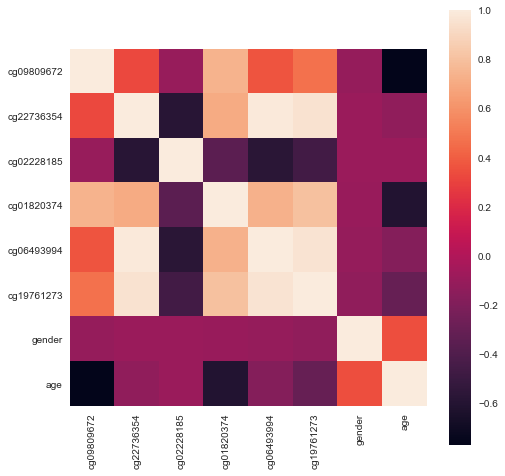

In [7]:
# Plot correlation matrix, or heatmap, to compare variables. As can 
# be seen in the lowest row (labelled age), the methylation sites
# that might act as the best predictors of age are cg09809672,
# cg01820374, and cg19761273.
C_mat = healthy_df.corr()
fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

In [8]:
# Normalizing the methylation and gender data with a Standard Scaler.
X = healthy_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]

# Separating X vs. y dataframes
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = healthy_df['age']

In [9]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Training the Models

## Linear Regression Model

Based on the score and predictions printed below, we see that the linear regression model is only somewhate capable of accurately predicting the age of an individual using the methylation levels inputted, with roughly 75% testing accuracy (varies with each run).

In [10]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(linear_regressor.score(X_test, y_test))

0.7449785322797969


In [11]:
predictions = linear_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i], "\tActual:", y_test.iloc[i])

Prediction: 0.0 	Actual: 0.0
Prediction: 6.456344999080628 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 13.475928770454352 	Actual: 8.0
Prediction: 16.10537837308491 	Actual: 16.25
Prediction: 14.569724811138357 	Actual: 11.0
Prediction: 0.38742860940671164 	Actual: 0.0
Prediction: 12.936513496438515 	Actual: 0.0
Prediction: 5.670004505153628 	Actual: 4.333333333
Prediction: 10.5852050716529 	Actual: 3.5


## Random Forest Regression Model

Looking at the score for the model below, we can see that the Random Forest Regressor model is quite accurate at predicting an individual's age using their methylation data, with roughly 92% testing accuracy (varies with each run).

In [12]:
# Building and training the Random Forest Regressor model
# Optimal value for n_estimators was determined by trial and error, comparing the score for each trial
random_forest_regressor = RandomForestRegressor(n_estimators = 17, random_state = 0)
random_forest_regressor.fit(X_train, y_train)

# Accuracy on the testing set
test_acc = random_forest_regressor.score(X_test, y_test)
print(test_acc)

0.9229559020455486


In [13]:
filename = "finalized_RFR_model.sav"
if (os.path.exists('finalized_RFR_model.sav')):
    random_forest_regressor_load = pickle.load(open(filename, 'rb'))
    if (random_forest_regressor_load.score(X_test, y_test) > test_acc):
        random_forest_regressor = random_forest_regressor_load
    else:
        pickle.dump(random_forest_regressor, open(filename, 'wb'))
else:
    pickle.dump(random_forest_regressor, open(filename, 'wb'))

In [14]:
predictions = random_forest_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
  print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 8.750000000588235 	Actual: 8.0
Prediction: 14.176470588235293 	Actual: 16.25
Prediction: 10.882352940764704 	Actual: 11.0
Prediction: 0.0 	Actual: 0.0
Prediction: 3.7205882352941178 	Actual: 0.0
Prediction: 5.093137254823529 	Actual: 4.333333333
Prediction: 4.411764706058824 	Actual: 3.5


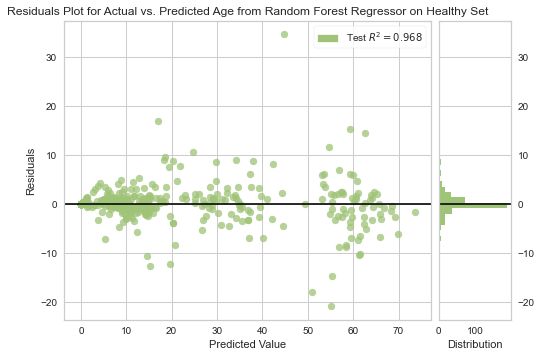

<AxesSubplot:title={'center':'Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Healthy Set'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Healthy Set")

visualizer.score(X_test, y_test)
visualizer.show()

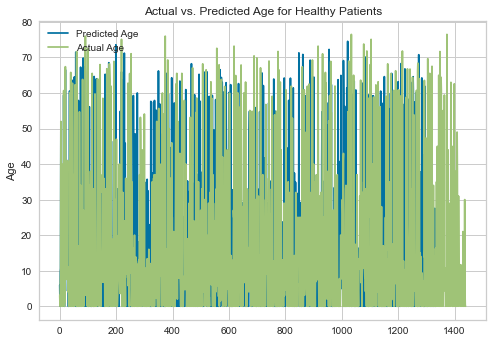

In [16]:
predictions = random_forest_regressor.predict(X)
plt.plot(predictions)
plt.plot(y)
plt.title("Actual vs. Predicted Age for Healthy Patients")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

## Gradient Boosting Regression Model

Looking at the two code blocks below, we see that the Gradient Boosting Regressor model, though not as accurate as the Random Forest Regressor, is still fairly accurate at generating the predictions using the data given, with roughly 86% accuracy on the testing set (varies with each run).

In [17]:
# Building and training the Gradient Boosting Regressor model

# The values of n_estimators, max_depth, and learning_rate were determined by trial and error,
# to obtain the obtimal values shown below.
params = {'n_estimators':3, 'max_depth':3, 'learning_rate': 1, 'criterion': 'mse'}

gradient_boosting_regressor = GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X_train, y_train)

print(gradient_boosting_regressor.score(X_test, y_test))

0.8806246662447894


In [18]:
predictions = gradient_boosting_regressor.predict(X_test)
for i in range(0, 10):
    if predictions[i] < 0:
        predictions[i] = 0
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 0.0 	Actual: 0.0
Prediction: 0.4172775239207656 	Actual: 0.0
Prediction: 13.326121404980286 	Actual: 0.0
Prediction: 8.20349076081665 	Actual: 8.0
Prediction: 13.326121404980286 	Actual: 16.25
Prediction: 8.20349076081665 	Actual: 11.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 4.333333333
Prediction: 6.492545630028501 	Actual: 3.5


## Regressive Neural Network

In [19]:
# Creating the sequential neural network model
NN_model = Sequential()

# Input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))


# Compile NN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


As seen in the plots showing the accuracy and loss as the model continues training, or the evaluation in the very last block, the neural network is extremely poor at predicting an individual's age, with an accuracy of around 30% (varies with each run).

In [20]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, verbose=0)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'accuracy', 'val_loss', 'val_mean_absolute_error', 'val_accuracy'])


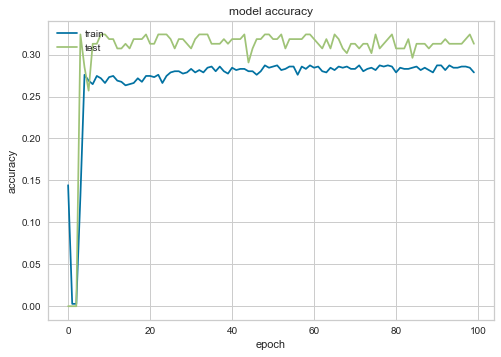

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

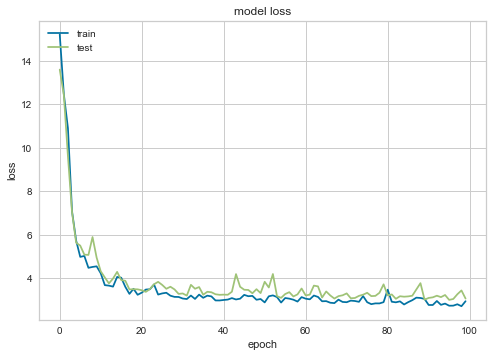

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
evaluation = NN_model.evaluate(X_test, y_test, batch_size=32)
loss = evaluation[0]
acc = evaluation[2]
print("Test loss:", loss)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 2ms/step - loss: 3.1892 - mean_absolute_error: 3.1892 - accuracy: 0.2948
Test loss: 3.189244508743286
Test accuracy: 0.2947845757007599


## Conclusion
With the code seen above, we conclude that the Random Forest Regression model is the best model of the four, and is able to fairly accurately predict an individual's age using their methylation levels at the 6 sites. Not far behind in accuracy is the Gradient Boosting model. The Linear Regression model is not as accurately able to predict the age, but is still able to do so much much more accurately than the neural network, which was only able to achieve a testing accuracy of roughly 30%, and validation accuracy ranging from 30-35%.

# Testing on Diseased Patients

Some of the models developed above are capable of accurately predicting the age of healthy individuals based on their methylation levels. However, if biological age is really a marker of one's health, then it should be expected that unhealthy individuals (or diseased individuals) should display methylation levels corresponding with a worse biological age. To test this, we import a large dataset of around 627 diseased individuals (after removing NaNs) and use the Random Forest Regressor (the model with the highest accuracy in the previous dataset) to compare the predicted biological age to their actual chronological age.

In [25]:
path = "./Datasets/Diseased/Disease_Methylation_Dataset.csv"
disease_df = pd.read_csv(path)
disease_df.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,GSM501491,0.665320,0.146727,0.627873,0.420957,0.093538,0.216396,0.0,29.0


In [26]:
# Remove patient ID column
disease_df = disease_df.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
disease_df = disease_df.dropna()

disease_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,0.665320,0.146727,0.627873,0.420957,0.093538,0.216396,0.0,29.0


In [27]:
disease_X = disease_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
disease_X = pd.DataFrame(std_scaler.fit_transform(disease_X), columns=disease_X.columns)
disease_Y = disease_df['age']
disease_predictions = []

try:
    disease_predictions = random_forest_regressor.predict(disease_X)
except NameError:
    if (os.path.exists('finalized_RFR_model.sav')):
        random_forest_regressor = pickle.load(open('finalized_RFR_model.sav', 'rb'))
        disease_predictions = random_forest_regressor.predict(disease_X)
    else:
        print("Please train the random forest regressor first.")

<a id='whole_comparison'></a>
### Comparing the Actual and Predicted Ages

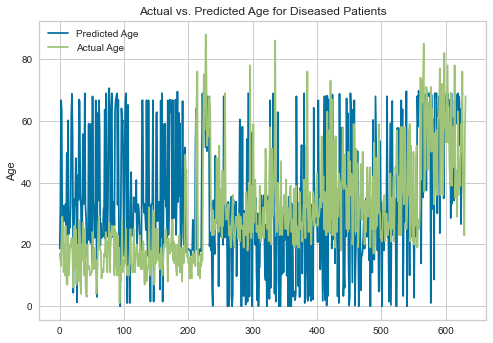

In [28]:
plt.plot(disease_predictions)
plt.plot(disease_Y)
plt.title("Actual vs. Predicted Age for Diseased Patients")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

As seen above, it seems that there is a chance that the predicted age is often lower than the actual age of many patients. To verify this, we plot a residual plot of the data below.

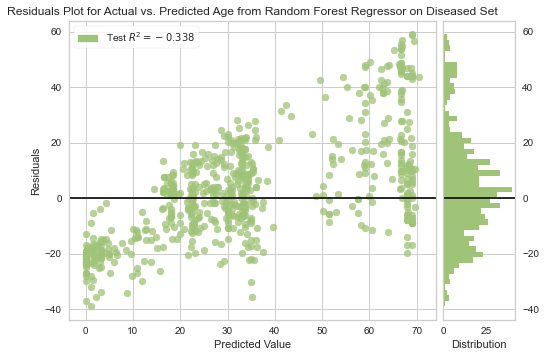

<AxesSubplot:title={'center':'Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Diseased Set'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
#from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Diseased Set")

visualizer.score(disease_X, disease_Y)
visualizer.show()

The residual plot shows a roughly normal distribution with an average residual (estimated by looking at the graph) close to 0. This suggests that the age predicted by the random forest regressor model trained above is not far from the actual age of the individual. This is interesting, since based on a lot of research that has been conducted by longevity scientists, individuals suffering from a chronic disease are generally biologically older than healthy individuals of the same age.

In [30]:
residuals = []
for i in range(0, len(disease_predictions)):
    residuals.append(disease_predictions[i] - disease_Y.iloc[i])
d = {'Actual Age': disease_Y, 'Predicted Age': disease_predictions, 'Residual (Actual - Predicted)': residuals}
disease_prediction_df = pd.DataFrame(data=d, dtype='int64')
disease_prediction_df.head()

,Actual Age,Predicted Age,Residual (Actual - Predicted)
0,17,18.686275,1.68627
1,15,32.647059,17.6471
2,13,66.668212,53.6682
3,22,63.708801,41.7088
4,29,23.890588,-5.10941


In [31]:
disease_prediction_df.to_csv("./Diseased_Predictions.csv")

Based on the graph comparing predicted vs. actual age over the entire diseased dataset (see [here](#whole_comparison)), we can see that there appears to be a few clearly distinct patterns throughout the graph, divided into distinct regions. This is likely due to the different diseases cohorts in the overall dataset, and so, to examine the effects of different diseases on the predicted vs. actual age comparison, we conduct smaller scale comparisons with each individual disease subset below.

## GSE20067

The first subset, GSE20067, is made of 194 Irish patients suffering from type 1 diabetes (T1D), which is caused by a dysfunctional pancreas that produces little or no insulin. You can find out more about T1D here: [Type 1 Diabetes](https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011).

In [32]:
path = "./Datasets/Diseased/GSE20067.csv"
GSE20067 = pd.read_csv(path)
GSE20067.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1,17
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0,15
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0,13
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0,22
4,GSM501491,0.665320,0.146727,0.627873,0.420957,0.093538,0.216396,0,29


In [33]:
# Remove patient ID column
GSE20067 = GSE20067.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE20067 = GSE20067.dropna()

GSE20067_X = GSE20067[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
GSE20067_X = pd.DataFrame(std_scaler.fit_transform(GSE20067_X), columns=GSE20067_X.columns)
GSE20067_Y = GSE20067['age']

GSE20067_predictions = random_forest_regressor.predict(GSE20067_X)

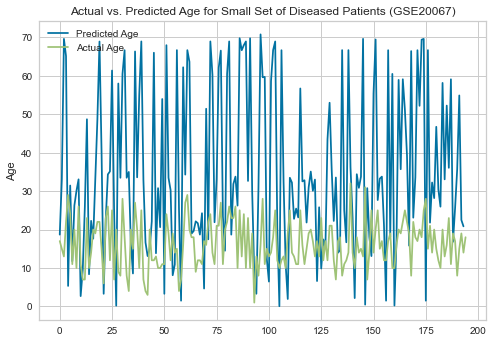

In [34]:
plt.plot(GSE20067_predictions)
plt.plot(GSE20067_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE20067)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

Above we see that, for this sample, the relation between actual and predicted age matches the pattern observed by longevity researchers, where we see that predicted age is often larger (by as much as 50 years for some patients) than the actual age for the diseased individuals. The same result can be observed in the residual plot below, which shows that the majority of residuals are positive, with an estimated mean residual (simply by looking at the graph) of positive 20-30 years.

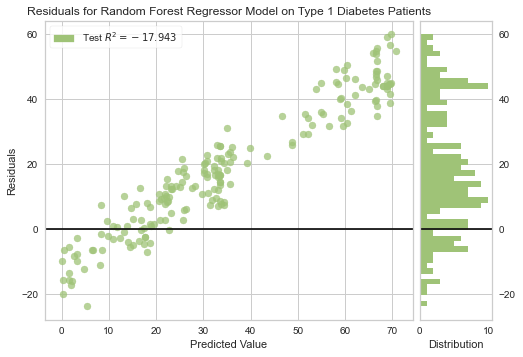

<AxesSubplot:title={'center':'Residuals for Random Forest Regressor Model on Type 1 Diabetes Patients'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals for Random Forest Regressor Model on Type 1 Diabetes Patients")

visualizer.score(GSE20067_X, GSE20067_Y)
visualizer.show()

## GSE32148

GSE32148 is made up of 27 patients suffering from Crohn's disease and ulcerative colitis. Find out more about Crohn's disease and ulcerative colitis [here](https://www.mayoclinic.org/diseases-conditions/crohns-disease/symptoms-causes/syc-20353304#:~:text=Crohn's%20disease%20is%20a%20type,digestive%20tract%20in%20different%20people) and [here](https://www.mayoclinic.org/diseases-conditions/ulcerative-colitis/symptoms-causes/syc-20353326), respectively.

In [36]:
path = "./Datasets/Diseased/GSE32148.csv"
GSE32148 = pd.read_csv(path)
GSE32148.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM796660,0.49584,0.26477,0.75742,0.34272,0.22242,0.31481,0,49.0
1,GSM796663,0.45375,0.28410,0.71584,0.31752,0.22214,0.28061,1,43.0
2,GSM796664,0.52961,0.28833,0.76346,0.36197,0.20132,0.26812,1,44.0
3,GSM796680,0.66473,0.23244,0.78634,0.43713,0.20471,0.38556,0,16.0
4,GSM796681,0.56968,0.20728,0.84090,0.36502,0.16907,0.34698,0,17.0


In [37]:
# Remove patient ID column
GSE32148 = GSE32148.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE32148 = GSE32148.dropna()

GSE32148_X = GSE32148[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
GSE32148_X = pd.DataFrame(std_scaler.fit_transform(GSE32148_X), columns=GSE32148_X.columns)
GSE32148_Y = GSE32148['age']

GSE32148_predictions = random_forest_regressor.predict(GSE32148_X)

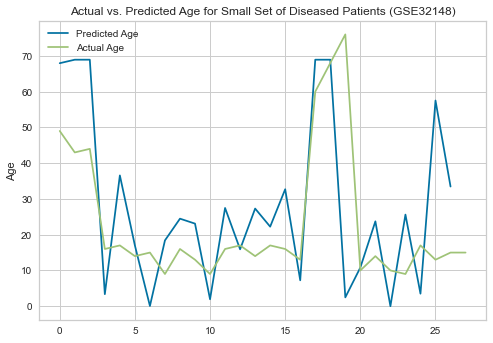

In [38]:
plt.plot(GSE32148_predictions)
plt.plot(GSE32148_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE32148)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

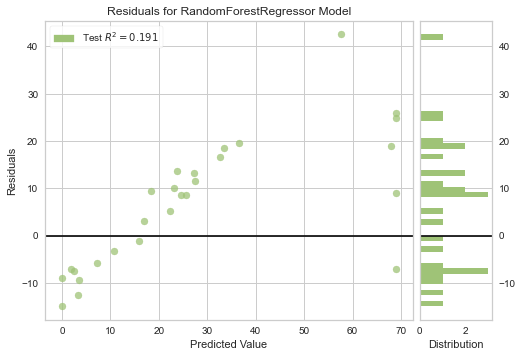

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [39]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE32148_X, GSE32148_Y)
visualizer.show()

Above we see that, for this sample, the relation between actual and predicted age is quite randomized, suggesting that the methylation levels in the blood is affected in different ways for different Crohn's disease and ulcerative colitis patients. Some patients might observe a methylation pattern characteristic of older healthy individuals, while others might display a methylation pattern similar to younger healthy individuals.

## GSE40005

GSE40005 is made up of 12 patients suffering from head and neck squamous cell carcinoma (HNSCC). Find out more about HNSCC [here](https://medlineplus.gov/genetics/condition/head-and-neck-squamous-cell-carcinoma/).

In [40]:
path = "./Datasets/Diseased/GSE40005.csv"
GSE40005 = pd.read_csv(path)
GSE40005.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM983212,0.50026,0.25563,0.87279,0.31466,0.21177,0.25882,1,57
1,GSM983213,0.36557,0.27511,0.59376,0.26102,0.24616,0.20894,1,75
2,GSM983214,0.41266,0.28788,0.70939,0.25144,0.22271,0.24892,1,57
3,GSM983215,0.32789,0.31877,0.62707,0.30550,0.24717,0.19671,0,68
4,GSM983216,0.40236,0.32457,0.66801,0.29342,0.24100,0.19468,0,88


In [41]:
# Remove patient ID column
GSE40005 = GSE40005.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE40005 = GSE40005.dropna()

GSE40005_X = GSE40005[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
GSE40005_X = pd.DataFrame(std_scaler.fit_transform(GSE40005_X), columns=GSE40005_X.columns)
GSE40005_Y = GSE40005['age']

GSE40005_predictions = random_forest_regressor.predict(GSE40005_X)

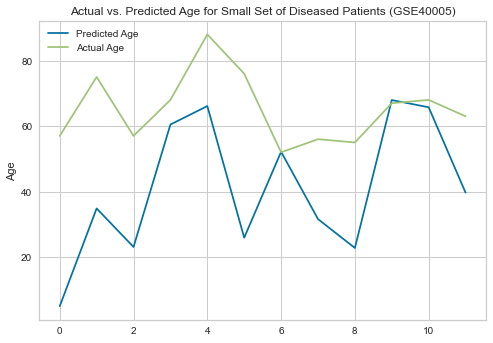

In [42]:
plt.plot(GSE40005_predictions)
plt.plot(GSE40005_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE40005)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

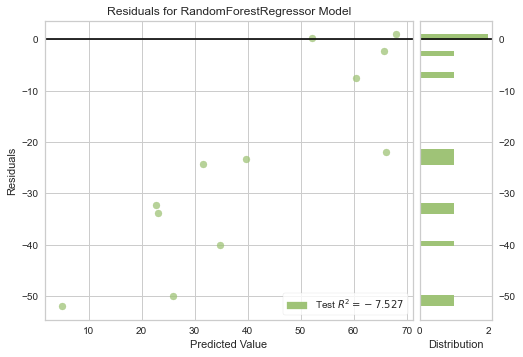

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE40005_X, GSE40005_Y)
visualizer.show()

The data above shows that the predicted age for all 12 HNSCC patients is lower than their actual age. This suggests a seemingly counterintuitive effect of HNSCC on blood methylation levels in these patients, where they display levels actually observed in younger, healthy patients. Interestingly, this has also been observed in the labs with some types of cancers, and even Dr. Horvath's initial clock displayed similar results with some cancers (discussed in this erratum [Erratum to: DNA methylation age of human tissues and cell types](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0649-6). As such, there is a possibility that, at least in this subset of patients, HNSCC is such a cancer that displays methylation patterns characteristic of a younger age.

## GSE41037

GSE41037 is made up of 323 patients suffering from schizophrenia. Find out more about schizophrenia [here](https://www.mayoclinic.org/diseases-conditions/schizophrenia/symptoms-causes/syc-20354443#:~:text=Schizophrenia%20is%20a%20serious%20mental,functioning%2C%20and%20can%20be%20disabling.).

In [44]:
path = "./Datasets/Diseased/GSE41037.csv"
GSE41037 = pd.read_csv(path)
GSE41037.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM1007129,0.546674,0.102902,0.701616,0.403573,0.077722,0.200886,0.0,34
1,GSM1007130,0.520461,0.125784,0.732436,0.412626,0.084386,0.238607,0.0,31
2,GSM1007131,0.449827,0.094724,0.573047,0.510932,0.049334,0.258955,0.0,23
3,GSM1007132,0.485862,0.130506,0.625189,0.574476,0.074315,0.236753,0.0,31
4,GSM1007133,0.557721,0.089979,0.716201,0.451005,0.086806,0.309545,0.0,23


In [45]:
# Remove patient ID column
GSE41037 = GSE41037.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE41037 = GSE41037.dropna()

GSE41037_X = GSE41037[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
GSE41037_X = pd.DataFrame(std_scaler.fit_transform(GSE41037_X), columns=GSE41037_X.columns)
GSE41037_Y = GSE41037['age']

GSE41037_predictions = random_forest_regressor.predict(GSE41037_X)

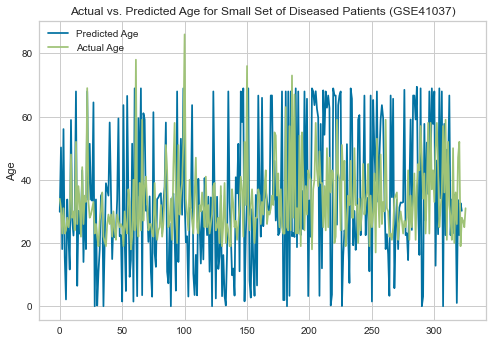

In [46]:
plt.plot(GSE41037_predictions)
plt.plot(GSE41037_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE41037)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

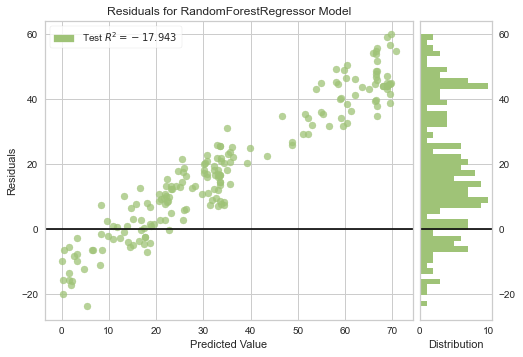

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [47]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE20067_X, GSE20067_Y)
visualizer.show()

The data above also shows results where the predicted bio-age was generally higher than the actual age, suggesting that schizophrenia does induce epigenetic changes even in the blood, which is intriguing since schizophrenia is more commonly thought of as being restricted to the nervous system in its effects. However, such observations have been widely categorized in schizophrenia patients ([Schizophrenia biomarkers: translating the descriptive into the diagnostic](https://pubmed.ncbi.nlm.nih.gov/25601396/)), with one study ([Epigenetic aberrations in leukocytes of patients with schizophrenia: association of global DNA methylation with antipsychotic drug treatment and disease onset](https://pubmed.ncbi.nlm.nih.gov/22426120/))finding global hypomethylation (reduced methylation across the genome) in white blood cells, showing that schizophrenia is not limited to the brain but does induce damage across the body.

## GSE49904

GSE49904 is made up of the epigenetic data collected from 71 patients of different ages.

In [48]:
path = "./Datasets/Diseased/GSE49904.csv"
GSE49904 = pd.read_csv(path)
GSE49904.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM1209271,0.334094,0.228276,0.667361,0.317091,0.144653,0.180146,0,74
1,GSM1209272,0.445935,0.189840,0.732337,0.371543,0.113562,0.227819,1,41
2,GSM1209273,0.353450,0.225520,0.669531,0.228571,0.112355,0.198376,1,73
3,GSM1209274,0.298207,0.232140,0.486732,0.261488,0.112436,0.141461,0,66
4,GSM1209275,0.227860,0.231000,0.426402,0.211383,0.125764,0.173659,0,74


In [49]:
# Remove patient ID column
GSE49904 = GSE49904.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE49904 = GSE49904.dropna()

GSE49904_X = GSE49904[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
GSE49904_X = pd.DataFrame(std_scaler.fit_transform(GSE49904_X), columns=GSE49904_X.columns)
GSE49904_Y = GSE49904['age']

GSE49904_predictions = random_forest_regressor.predict(GSE49904_X)

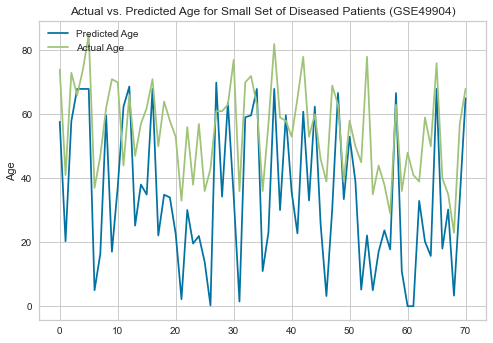

In [50]:
plt.plot(GSE49904_predictions)
plt.plot(GSE49904_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE49904)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

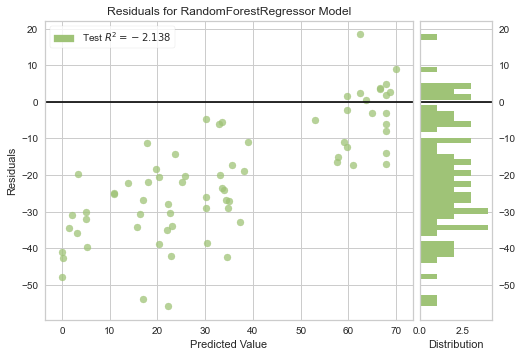

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [51]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE49904_X, GSE49904_Y)
visualizer.show()

The residual plot and line graph above shows that the average difference between predicted and actual age is negative (predicted age is less than actual age) for these aged individuals. This is interesting to see since it suggests that the blood of these individuals, for some reason shows methylation patterns more indicative of younger individuals. This could be a tissue-based difference, or might involve errors in the random forest regression model and its accuracy itself.

## Conclusion
As can be seen above with the separate datasets above, the relationship between predicted and actual age of diseased individuals varies largely with the disease itself. More work and research into characterizing the profiles of each disease in terms of the effects they have on the epigenetic patterns is needed, along with more research into interventions like epigenetic reprogramming (resetting an abnormal epigenome to one characteristic of a healthier body) to slow the effects of ageing.